In [ ]:
# %pip install pytesseract
# %pip install mss pydirectinput 
# Install stable-baselines3 for gymnasium
# %pip install git+https://github.com/DLR-RM/stable-baselines3

In [1]:
from mss import mss
import os
import pydirectinput
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
import cv2
import time
import gymnasium as gym
from matplotlib import pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

# from keras import Sequential
# from keras.layers import Dense, Flatten
# from keras.optimizers import Adam
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback

# from stable_baselines3.common.utils import set_random_seed


In [2]:
class GameEnv(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape = (1,83,120), dtype = np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.agent_location = {'top':300, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70}
        
    def step(self, action):
        action_map = {
            0:'space', #Jump
            1:'down', #Duck
            2:'no_op' #Run
            }
        if action != 2:
            pydirectinput.press(action_map[action]) # type: ignore
        over, over_cap = self.game_over()
        next_obs = self.get_observation()
        reward = 10
        truncation = 0 #Limit is 99999, then score changes to zero
        info = {}
        return next_obs, reward, over,truncation, info

    def render(self):
        pass
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
        return self.get_observation() ,{}

    def close(self):
        pass

    def get_observation(self):
        #Screen capture
        raw = np.array(self.cap.grab(self.agent_location))[:,:,:3]
        #convert to greyscale(reduces size)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        #resize to match observation space
        resize = cv2.resize(gray, (120,83))
        #reshape for pytorch
        channel = np.reshape(resize, (1,83,120))
        return channel
    
    def game_over(self):
        over_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        over_ind = ['GAME', 'GAHE']
        over = False
        res = pytesseract.image_to_string(over_cap)[:4]
        if res in over_ind:
            over = True
        return over, over_cap

In [3]:
env = GameEnv()

In [ ]:
# env.reset()

In [4]:
env.action_space.sample()

1

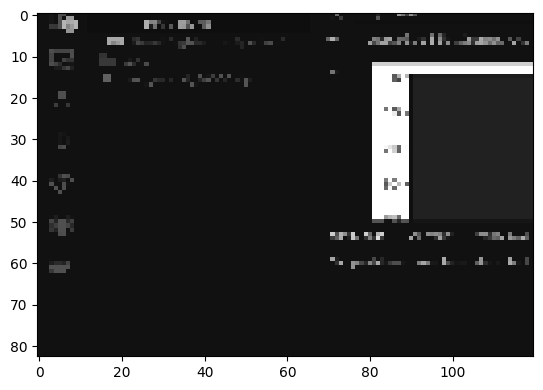

In [5]:
obs = env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

# Training time

In [8]:
# for episode in range(5):
#     obs = env.reset()
#     over = False
#     tot_reward = 0

#     while not over:
#         obs, reward, over, info = env.step(env.action_space.sample())
#         tot_reward += reward
#     print(f'Episode : {episode}, Reward : {tot_reward}')

In [9]:
# tot_states = env.observation_space.shape
# # tot_actions = 3 #Figure out later

In [ ]:

# from stable_baselines3.common import env_checker

In [6]:
class TrainLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose = 1):
        super(TrainLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True


In [7]:
CHECKPOINT_DIR = 'C:/Users/nikit/Desktop/Personal Projects/RLmodels/codes/Dino/train'
LOG_DIR = 'C:/Users/nikit/Desktop/Personal Projects/RLmodels/codes/Dino/logs'

In [8]:
callback = TrainLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [12]:
# import random

# import torch


total_timesteps = 1200000  # Total number of steps for training
batch_size = 40000  # Number of steps per training iteration

# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

# Create the DQN model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=batch_size, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [26]:
model.load('C:/Users/nikit/Desktop/Personal Projects/RLmodels/codes/Dino/train/best_model_111000.zip')

In [28]:
model.learn(total_timesteps=1200000, callback=callback)

Logging to C:/Users/nikit/Desktop/Personal Projects/RLmodels/codes/Dino/logs\DQN_115
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 160      |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 34       |
|    total_timesteps  | 64       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15       |
|    ep_rew_mean      | 150      |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 66       |
|    total_timesteps  | 120      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 155      |
|    

KeyboardInterrupt: 

In [24]:
# Perform incremental learning in multiple iterations
current_timestep = 0
while current_timestep < total_timesteps:
    # Calculate the number of steps for this iteration
    remaining_timesteps = total_timesteps - current_timestep
    num_steps = min(batch_size, remaining_timesteps)

    # model.set_random_seed(1000)

    # Train the model for the current iteration
    model.learn(total_timesteps=num_steps, callback=callback)

    # Update the current timestep
    current_timestep += num_steps

Logging to C:/Users/nikit/Desktop/Personal Projects/RLmodels/codes/Dino/logs\DQN_69
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 162      |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 33       |
|    total_timesteps  | 65       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.2     |
|    ep_rew_mean      | 182      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 75       |
|    total_timesteps  | 146      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18       |
|    ep_rew_mean      | 180      |
|    e

KeyboardInterrupt: 

In [25]:
for episode in range(5):
    obs = env.reset()[0]
    over = False
    tot_reward = 0

    while not over:
        action = model.predict(obs)
        obs, reward, over, info, _ = env.step(env.action_space.sample())
        # time.sleep(0.01)
        tot_reward += reward
    print(f'Episode : {episode}, Reward : {tot_reward}')
    time.sleep(2)

Episode : 0, Reward : 110
Episode : 1, Reward : 140
Episode : 2, Reward : 220


KeyboardInterrupt: 

In [18]:
print(stable_baselines3.__version__)

2.0.0a13


In [ ]:
# model = modelBuilder(tot_states, tot_actions)

In [ ]:
# model.summary()

In [ ]:
# def agentBuilder(model, actions):
#     policy = BoltzmannQPolicy()
#     memory = SequentialMemory(limit=50000, window_length=1)
#     dqn = DQNAgent(model=model,
#                    memory=memory,
#                    policy=policy,
#                    nb_actions=actions,
#                    nb_steps_warmup = 10,
#                    target_model_update=1e-2
#                    )
#     return dqn
   

In [ ]:
# dqn = agentBuilder(model, tot_actions)
# dqn.compile(optimizer='Adam',metrics = ['mae'])
 # dqn.fit(env, nb_steps=50000, verbose = 1, visualize=False)